# Temperature Quantile Theory variation with latitude
This notebook looks at trying to estimate the temperature above a given quantile using each of four theories. It looks at how each of these theories work over different latitudes.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.


In [8]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore

In [3]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer for a given latitude bin.

In [51]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2

lat_width = 20
lat_min = np.arange(0, 90, lat_width)
lat_max = lat_min + lat_width
lat_centre = lat_min + lat_width/2  # Central absolute latitude for given latitude bin
n_lat = len(lat_min)

ds_all = [[], []]
with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
        for j in range(n_lat):
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(
                lat=slice(lat_min[j], lat_max[j]))    # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(
                lat=slice(-lat_max[j], -lat_min[j]))    # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use2 = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
            # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
            ds_use2 = ds_use2.sel(lon_lat_time = ds_use2.lon_lat_time[np.invert(np.isnan(ds_use2.temp[-1]))].to_numpy())
            ds_all[i] += [ds_use2]
            ds_all[i][j].load()     # Load in dataset
            pbar.update(1)

100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


In [52]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

quant_use = 95     # first value must be 0 so temp_quant[0] is the mean value

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = np.zeros((n_exp, n_lat))
sphum_quant = np.zeros((n_exp, n_lat))
z_quant = np.zeros((n_exp, n_lat))
mse_quant = np.zeros((n_exp, n_lat))


with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            use_ind = get_quant_ind(ds_all[i][j], quant_use)
            temp_quant[i, j] = np.mean(ds_all[i][j].temp[-1][use_ind])
            sphum_quant[i, j] = np.mean(ds_all[i][j].sphum[-1][use_ind])
            z_quant[i, j] = np.mean(ds_all[i][j].height[-1][use_ind])
            mse_quant[i, j] = np.mean(moist_static_energy(ds_all[i][j].temp[-1][use_ind],
                                                          ds_all[i][j].sphum[-1][use_ind],
                                                          ds_all[i][j].height[-1][use_ind]))
            pbar.update(1)

100%|██████████| 10/10 [00:00<00:00, 49.31it/s]


In [53]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = np.zeros((n_exp, n_lat))
with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            mse_all = moist_static_energy(ds_all[i][j].temp[-1], ds_all[i][j].sphum[-1], ds_all[i][j].height[-1])
            mse_quant_px[i, j] = percentileofscore(mse_all, mse_quant[i, j])
            pbar.update(1)

100%|██████████| 10/10 [00:00<00:00, 58.64it/s]


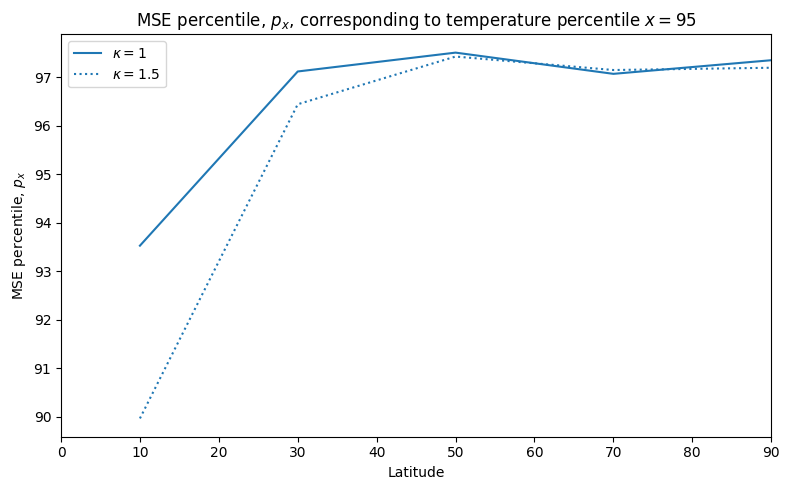

In [54]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
for i in range(n_exp):
    ax.plot(lat_centre, mse_quant_px[i], color=default_colors[0], linestyle=linestyles[i],
            label=f'$\kappa={tau_lw[i]}$')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('MSE percentile, $p_x$')
ax.set_title(f'MSE percentile, $p_x$, corresponding to temperature percentile $x={quant_use}$')
ax.set_xlim(0,90)
plt.tight_layout();

In [55]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat))

temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))

with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            # Find percentiles corresponding to p^x in the reference simulation hence always quant_px[0, j]
            temp_quant2[i, j] = ds_all[i][j].temp[-1].quantile(mse_quant_px[0, j]/100, dim='lon_lat_time', keep_attrs=True)
            temp_mean[i, j] = ds_all[i][j].temp[-1].mean()
            sphum_quant2[i, j] = ds_all[i][j].sphum[-1].quantile(mse_quant_px[0, j]/100, dim='lon_lat_time', keep_attrs=True)
            sphum_mean[i, j] = ds_all[i][j].sphum[-1].mean()
            mse_all = moist_static_energy(ds_all[i][j].temp[-1], ds_all[i][j].sphum[-1], ds_all[i][j].height[-1])
            mse_quant2[i, j] = mse_all.quantile(mse_quant_px[0, j]/100, dim='lon_lat_time', keep_attrs=True)
            mse_mean[i, j] = mse_all.mean()
            pbar.update(1)

100%|██████████| 10/10 [00:00<00:00, 22.78it/s]


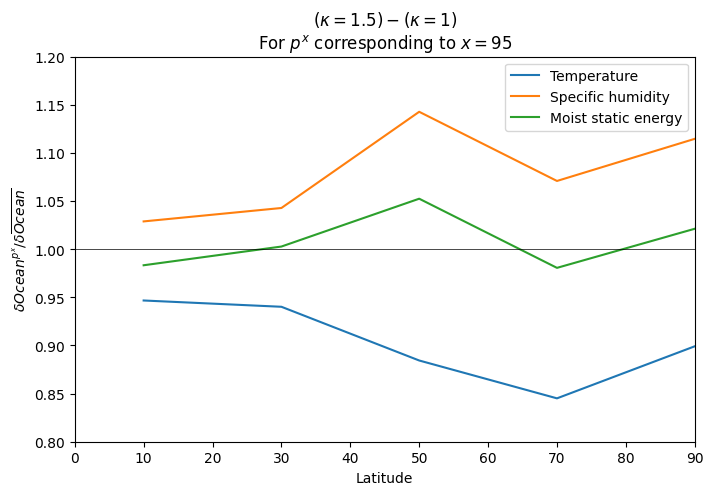

In [56]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [var[1] - var[0] for var in [temp_mean, sphum_mean, mse_mean]]
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    if i == 2:
        # For mse change, this is the lambda constant
        lambda_px = (var[1]-var[0])/delta_var_mean[i]
    ax.plot(lat_centre, (var[1]-var[0])/delta_var_mean[i], label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('$\delta Ocean^{p^x}/\delta \overline{Ocean}$')
ax.set_ylim(0.8,1.2)
ax.set_xlim(0, 90)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\nFor $p^x$ corresponding to $x={quant_use}$');

In [57]:
# Get actual delta_h from change in quantile formula
delta_h = np.zeros(n_lat)
for j in range(n_lat):
    mse_all = moist_static_energy(ds_all[1][j].temp[-1], ds_all[1][j].sphum[-1], ds_all[1][j].height[-1])
    delta_h[j] = np.quantile(mse_all, mse_quant_px[1, j]/100) - np.quantile(mse_all, mse_quant_px[0, j]/100)

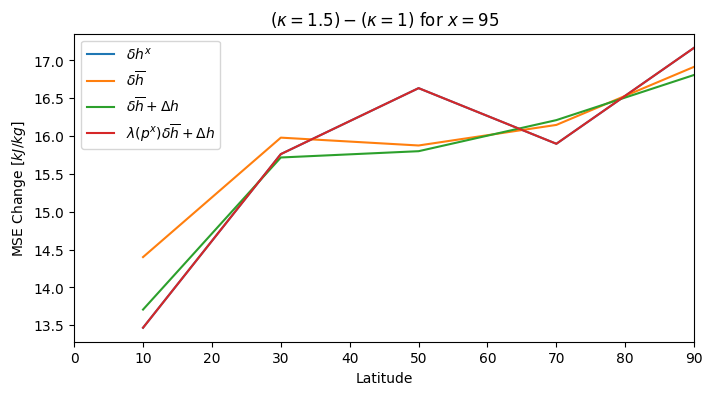

In [67]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(lat_centre, mse_quant[1]-mse_quant[0], label='$\delta h^x$')
ax.plot(lat_centre, mse_mean[1]-mse_mean[0], label='$\delta \overline{h}$')
ax.plot(lat_centre, mse_mean[1]-mse_mean[0] + delta_h, label='$\delta \overline{h} + \Delta h$')
ax.plot(lat_centre, lambda_px * (mse_mean[1]-mse_mean[0]) + delta_h,
        label = '$\lambda(p^x) \delta \overline{h} + \Delta h$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlabel('Latitude')
ax.legend()
ax.set_xlim(0,90)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$ for $x={quant_use}$');

In [68]:
# Variables required for Delta T theory
p_surface = float(ds_all[0][0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1 + w_sat)
    return q_sat

def clausius_clapeyron_factor2(temp):
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65) ** 2
    return lambda_const * p_surface / epsilon * sphum_sat(temp, p_surface) / saturation_vapor_pressure(temp)

# Land constants required - all averaged over the x percentile temperature day
# i.e. there are 100 values for each of these constants
q_x_sat = sphum_sat(temp_quant[0], p_surface)
q_mean_sat = sphum_sat(temp_mean[0], p_surface)
q_x = sphum_quant[0]
r_x = q_x / q_x_sat
delta_r_x = sphum_quant[1] / sphum_sat(temp_quant[1], p_surface) - r_x
r_mean = sphum_mean[0] / q_mean_sat
delta_r_mean = sphum_mean[1] / sphum_sat(temp_mean[1], p_surface) - r_mean
alpha = clausius_clapeyron_factor2(temp_quant[0])
alpha_mean = clausius_clapeyron_factor2(temp_mean[0])

delta_temp_quant = temp_quant[1] - temp_quant[0]
delta_temp_mean = temp_mean[1] - temp_mean[0]
delta_mse_mean = mse_mean[1] - mse_mean[0]

In [73]:
# Variables required for Delta h theory
p_mean = np.zeros((n_exp, n_lat))
beta1 = np.zeros((n_exp, n_lat))
beta2 = np.zeros((n_exp, n_lat))

all_quant = np.arange(100)
with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            mse_all = moist_static_energy(ds_all[i][j].temp[-1], ds_all[i][j].sphum[-1], ds_all[i][j].height[-1])
            p_mean[i, j] = percentileofscore(mse_all.to_numpy(), mse_mean[i, j])
            mse_all = mse_all.quantile(all_quant/100, dim='lon_lat_time', keep_attrs=True)
            beta1[i, j] = np.gradient(mse_all, all_quant)[int(np.round(p_mean[i, j]))]
            beta2[i, j] = np.gradient(mse_all, all_quant)[np.round(mse_quant_px[0, j]).astype(int)]
            pbar.update(1)

# p_mean = int(np.round(percentileofscore(mse_all, float(np.mean(mse_all)))))
# beta1 = np.gradient(mse_quant2[0], quant_plot)[p_mean]
delta_h_theory = L_v/1000 * (delta_r_x * q_x_sat - delta_r_mean * q_mean_sat)
delta_h_theory2 = L_v/1000 * (delta_r_x * q_x_sat + q_x_sat * alpha * delta_r_x * delta_temp_quant -
                              delta_r_mean * q_mean_sat - q_mean_sat * alpha_mean * delta_r_mean * delta_temp_mean)

100%|██████████| 10/10 [00:00<00:00, 17.05it/s]


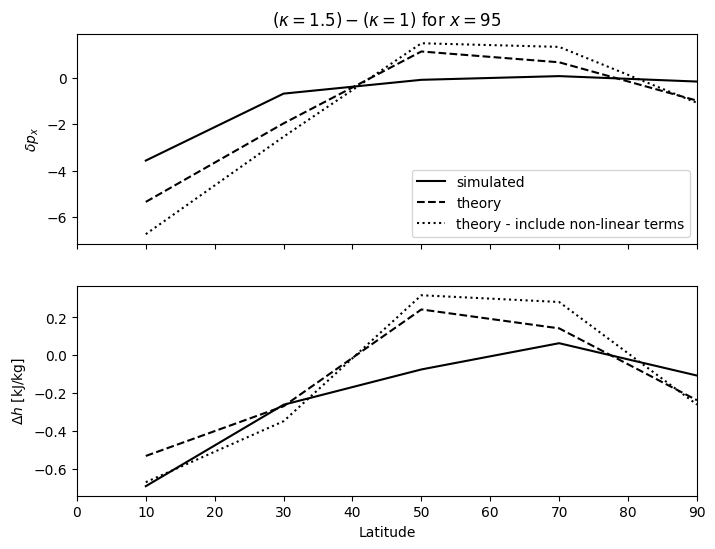

In [74]:
fig_delta_h, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(lat_centre, mse_quant_px[1] - mse_quant_px[0], color='k', label='simulated')
ax[0].plot(lat_centre, delta_h_theory / beta1[0], color='k', linestyle='--', label='theory')
ax[0].plot(lat_centre, delta_h_theory2 / beta1[0], color='k', linestyle=':', label='theory - include non-linear terms')
ax[1].plot(lat_centre, delta_h, color='k', label='simulated')
ax[1].plot(lat_centre, delta_h_theory, color='k', linestyle='--', label='theory')
ax[1].plot(lat_centre, delta_h_theory2, color='k', linestyle=':', label='theory - include non-linear terms')
ax[0].legend()
ax[0].set_ylabel('$\delta p_x$')
ax[1].set_ylabel('$\Delta h$ [kJ/kg]')
ax[1].set_xlabel('Latitude')
ax[0].set_xlim([0,90])
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$ for $x={quant_use}$');

In [75]:
term0 = c_p * delta_temp_quant
term1 = L_v * alpha * q_x * delta_temp_quant
term2 = L_v * q_x_sat * delta_r_x
term3 = L_v * q_x_sat * alpha * delta_r_x * delta_temp_quant
term4 = 0.5 * L_v * q_x * alpha * (alpha - 2/temp_quant[0])*delta_temp_quant**2
mse_taylor_terms = np.asarray([term0, term1, term2, term3, term4])

term0 = c_p * delta_temp_mean
term1 = L_v * alpha_mean * sphum_mean[0] * delta_temp_mean
term2 = L_v * q_mean_sat * delta_r_mean
term3 = L_v * q_mean_sat * alpha_mean * delta_r_mean * delta_temp_mean
term4 = 0.5 * L_v * sphum_mean[0] * alpha_mean * (alpha_mean - 2/temp_mean[0])*delta_temp_mean**2
mse_mean_taylor_terms = np.asarray([term0, term1, term2, term3, term4])

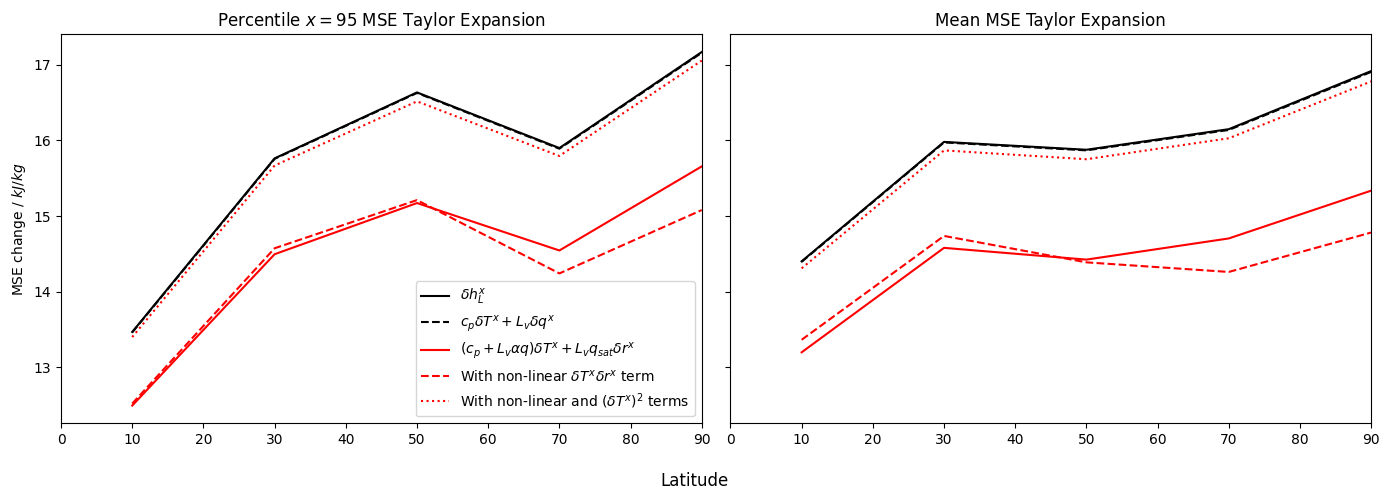

In [84]:
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
# Plot for percentile x
ax[0].plot(lat_centre, mse_quant[1]-mse_quant[0], color='k', label='$\delta h^x_L$')
ax[0].plot(lat_centre, (c_p * (temp_quant[1]-temp_quant[0]) + L_v * (sphum_quant[1] - sphum_quant[0]))/1000, color='k',
        label='$c_p \delta T^x + L_v \delta q^x$', linestyle='--')
ax[0].plot(lat_centre, np.sum(mse_taylor_terms[:3], axis=0)/1000, color='r',
        label='$(c_p+L_v\\alpha q) \delta T^x + L_v q_{sat} \delta r^x$')
ax[0].plot(lat_centre, np.sum(mse_taylor_terms[:4], axis=0)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T^x \delta r^x$ term')
ax[0].plot(lat_centre, np.sum(mse_taylor_terms, axis=0)/1000, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x)^2$ terms')
ax[0].set_title(f'Percentile $x={quant_use}$ MSE Taylor Expansion')
# Plot for mean
ax[1].plot(lat_centre, mse_mean[1]-mse_mean[0], color='k', label='$\delta h^x_L$')
ax[1].plot(lat_centre, (c_p * (temp_mean[1]-temp_mean[0]) + L_v * (sphum_mean[1] - sphum_mean[0]))/1000, color='k',
        label='$c_p \delta T^x + L_v \delta q^x$', linestyle='--')
ax[1].plot(lat_centre, np.sum(mse_mean_taylor_terms[:3], axis=0)/1000, color='r',
        label='$(c_p+L_v\\alpha q) \delta T^x + L_v q_{sat} \delta r^x$')
ax[1].plot(lat_centre, np.sum(mse_mean_taylor_terms[:4], axis=0)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T^x \delta r^x$ term')
ax[1].plot(lat_centre, np.sum(mse_mean_taylor_terms, axis=0)/1000, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x)^2$ terms')
ax[1].set_title('Mean MSE Taylor Expansion')
ax[0].legend()
fig.supxlabel('Latitude')
ax[0].set_ylabel('MSE change / $kJ/kg$')
ax[0].set_xlim(0,90)
plt.tight_layout();

In [96]:
e_const = L_v * alpha * q_x_sat / (c_p + L_v * alpha * q_x)
# Theory 1 - No assumptions
denom = c_p + L_v * alpha * q_x
coef_a = 0.5 * L_v * alpha * q_x * (alpha - 2/temp_quant[0]) / denom
coef_b = 1 + e_const * delta_r_x
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * delta_mse_mean*1000 + 1000*delta_h)/denom
temp_diff_land_theory_1 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_lat)])

# Theory 2 - Assume equal changes in percentile p of MSE over ocean and land
coef_c = e_const/alpha * delta_r_x - (delta_mse_mean*1000 + 1000*delta_h)/denom
temp_diff_land_theory_2 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_lat)])

# Theory 4 - With theory in paper for delta_h
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * delta_mse_mean * 1000 + 1000*delta_h_theory)/denom
temp_diff_land_theory_4 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_lat)])

# Theory 5 - Taylor expansion including non-linear and squared terms for mean MSE change
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms, axis=0) + 1000 * delta_h)/denom
temp_diff_land_theory_5 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_lat)])

# Theory 6 - Neglect squared term in taylor expansion of x and mean but keep non linear for both
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_6 = -coef_c/coef_b

# Theory 7 - Neglect squared term and non-linear term in mean, neglect squared term in x.
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms[:3], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_7 = -coef_c/coef_b

# Theory 8 - Neglect squared term and non-linear term in mean and x.
coef_b = 1
temp_diff_land_theory_8 = -coef_c/coef_b

# Theory 9 - neglect squared term and non-linear term in mean and x. Also, assume lambda=1 and use theory for delta_h including
# just linear terms - gives same value as below which includes non-linear stuff.
coef_b = 1
coef_c = e_const/alpha * delta_r_x - (
         np.sum(mse_mean_taylor_terms[:3], axis=0) + 1000*delta_h_theory)/denom
temp_diff_land_theory_9 = -coef_c/coef_b
# # Theory 9 - neglect squared term but keep non-linear term in mean and x. Also, assume lambda=1 and use theory for delta_h
# # including non-linear terms - gives same value as above just linear case.
# coef_b = 1 + e_const * delta_r_x
# coef_c = e_const/alpha * delta_r_x - (
#          np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h_theory2)/denom
# temp_diff_land_theory_9 = -coef_c/coef_b

# Theory 10 - Neglect squared term in taylor expansion of x and mean but keep non linear for both.
# Also use theory for delta_h including just linear terms
coef_b = 1 + e_const * delta_r_x
coef_c = e_const/alpha * delta_r_x - (np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h_theory)/denom
temp_diff_land_theory_10 = -coef_c/coef_b

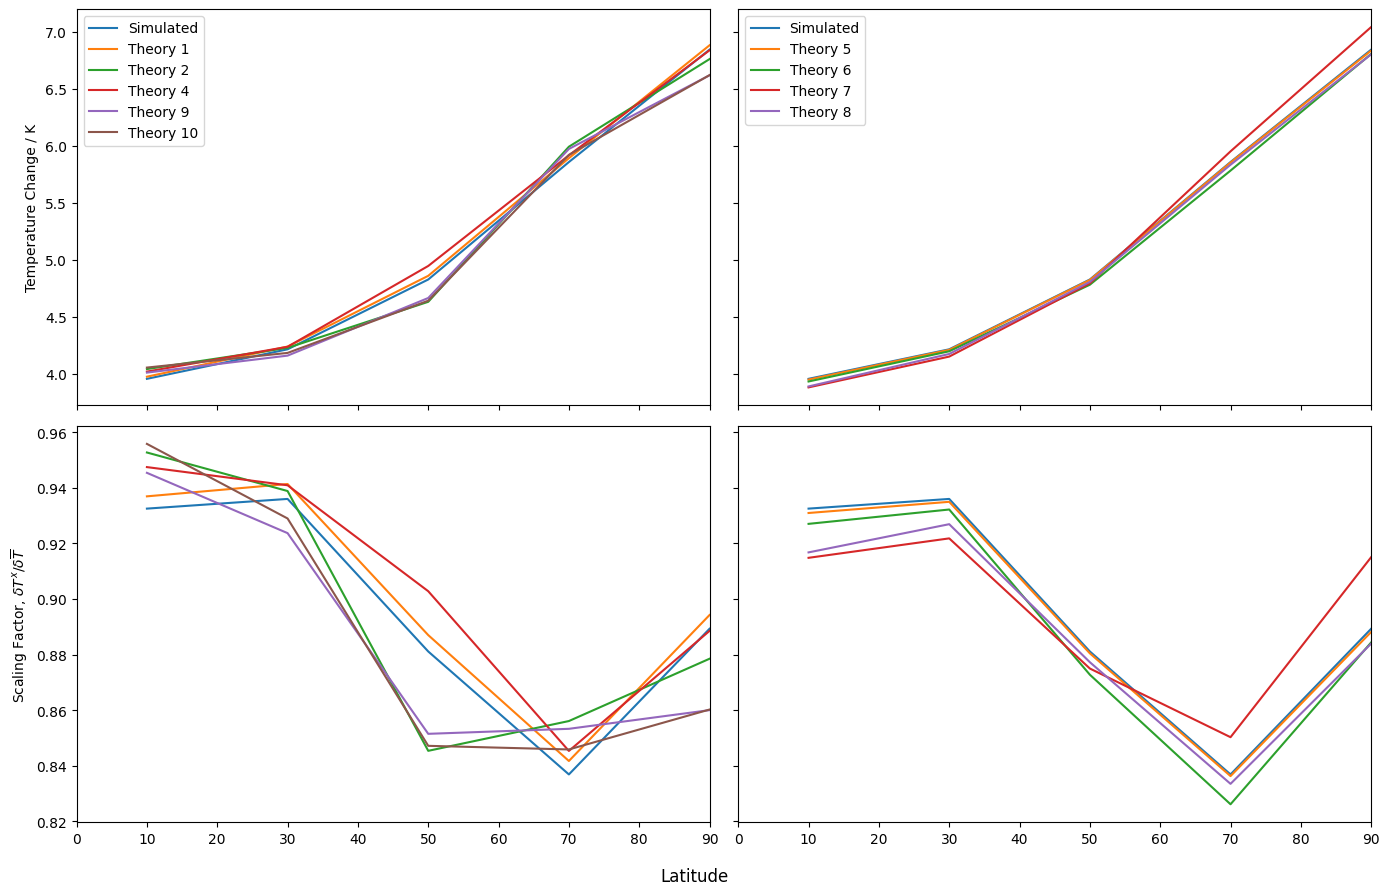

In [99]:
fig, ax = plt.subplots(2,2, figsize=(14, 9), sharex=True, sharey='row')
ax = ax.flatten()
ax[0].plot(lat_centre, delta_temp_quant, label='Simulated')
ax[0].plot(lat_centre, temp_diff_land_theory_1, label='Theory 1')
ax[0].plot(lat_centre, temp_diff_land_theory_2, label='Theory 2')
ax[0].plot(lat_centre, temp_diff_land_theory_4, label='Theory 4')
ax[0].plot(lat_centre, temp_diff_land_theory_9, label='Theory 9')
ax[0].plot(lat_centre, temp_diff_land_theory_10, label='Theory 10')

ax[2].plot(lat_centre, delta_temp_quant/delta_temp_mean, label='Simulated')
ax[2].plot(lat_centre, temp_diff_land_theory_1/delta_temp_mean, label='Theory 1')
ax[2].plot(lat_centre, temp_diff_land_theory_2/delta_temp_mean, label='Theory 2')
ax[2].plot(lat_centre, temp_diff_land_theory_4/delta_temp_mean, label='Theory 4')
ax[2].plot(lat_centre, temp_diff_land_theory_9/delta_temp_mean, label='Theory 9')
ax[2].plot(lat_centre, temp_diff_land_theory_10/delta_temp_mean, label='Theory 10')

ax[1].plot(lat_centre, delta_temp_quant, label='Simulated')
ax[1].plot(lat_centre, temp_diff_land_theory_5, label='Theory 5')
ax[1].plot(lat_centre, temp_diff_land_theory_6, label='Theory 6')
ax[1].plot(lat_centre, temp_diff_land_theory_7, label='Theory 7')
ax[1].plot(lat_centre, temp_diff_land_theory_8, label='Theory 8')

ax[3].plot(lat_centre, delta_temp_quant/delta_temp_mean, label='Simulated')
ax[3].plot(lat_centre, temp_diff_land_theory_5/delta_temp_mean, label='Theory 5')
ax[3].plot(lat_centre, temp_diff_land_theory_6/delta_temp_mean, label='Theory 6')
ax[3].plot(lat_centre, temp_diff_land_theory_7/delta_temp_mean, label='Theory 7')
ax[3].plot(lat_centre, temp_diff_land_theory_8/delta_temp_mean, label='Theory 8')

ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0,90])
ax[0].set_ylabel('Temperature Change / K')
ax[2].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
fig.supxlabel('Latitude')
plt.tight_layout();

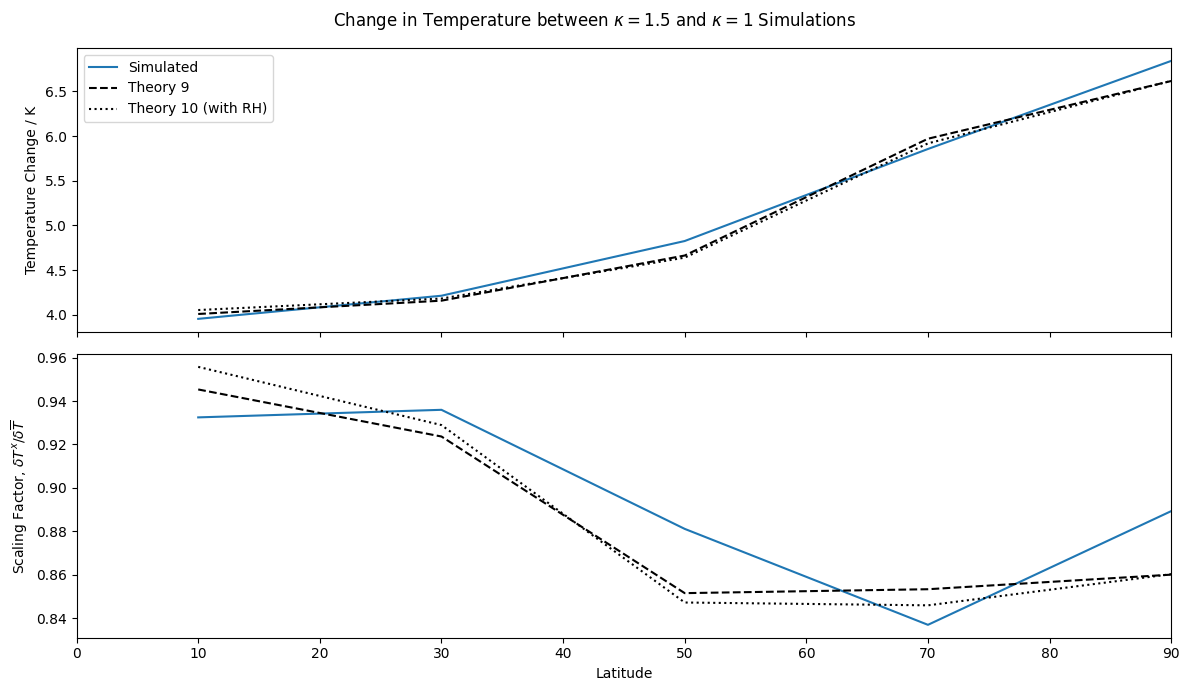

In [106]:
fig, ax = plt.subplots(2,1, figsize=(12, 7), sharex=True)
ax[0].plot(lat_centre, delta_temp_quant, label='Simulated', color=default_colors[0])
ax[1].plot(lat_centre, delta_temp_quant/delta_temp_mean, color=default_colors[0])
ax[0].plot(lat_centre, temp_diff_land_theory_9, label='Theory 9', linestyle='--', color='k')
ax[0].plot(lat_centre, temp_diff_land_theory_10, label='Theory 10 (with RH)', linestyle=':', color='k')
ax[1].plot(lat_centre, temp_diff_land_theory_9/delta_temp_mean, label=f'Theory 9', linestyle='--', color='k')
ax[1].plot(lat_centre, temp_diff_land_theory_10/delta_temp_mean, label='Theory 10 (with RH)', linestyle=':', color='k')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Latitude')
ax[0].legend()
ax[0].set_xlim(0,90)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.9, 1.25)
plt.suptitle(f"Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations")
plt.tight_layout();